In [1]:
# Standard library imports
import os
import tempfile
import csv
import gzip
import json
from getpass import getpass

# Elasticsearch client
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from elasticsearch.helpers import bulk

# Eland imports for Elasticsearch and pandas integration
import eland as ed
from eland.conftest import *

# Third-party imports for data handling
import pandas as pd
import numpy as np

# Visualization library
import matplotlib.pyplot as plt

# HTTP requests library
import requests


In [4]:

es_kwargs = {
    "hosts": "https://localhost:9200",
    "basic_auth": ('elastic', 'pass.123')
}

es = Elasticsearch(**es_kwargs, ca_certs='./ca.crt')
es_info = es.info()
print(f"Connected to cluster named '{es_info['cluster_name']}' (version: {es_info['version']['number']})")


Connected to cluster named 'docker-cluster' (version: 8.15.0)


In [5]:

FLIGHTS_INDEX_NAME = "flights"
FLIGHTS_MAPPING = {
    "mappings": {
        "properties": {
            "AvgTicketPrice": {"type": "float"},
            "Cancelled": {"type": "boolean"},
            "Carrier": {"type": "keyword"},
            "Dest": {"type": "keyword"},
            "DestAirportID": {"type": "keyword"},
            "DestCityName": {"type": "keyword"},
            "DestCountry": {"type": "keyword"},
            "DestLocation": {"type": "geo_point"},
            "DestRegion": {"type": "keyword"},
            "DestWeather": {"type": "keyword"},
            "DistanceKilometers": {"type": "float"},
            "DistanceMiles": {"type": "float"},
            "FlightDelay": {"type": "boolean"},
            "FlightDelayMin": {"type": "integer"},
            "FlightDelayType": {"type": "keyword"},
            "FlightNum": {"type": "keyword"},
            "FlightTimeHour": {"type": "float"},
            "FlightTimeMin": {"type": "float"},
            "Origin": {"type": "keyword"},
            "OriginAirportID": {"type": "keyword"},
            "OriginCityName": {"type": "keyword"},
            "OriginCountry": {"type": "keyword"},
            "OriginLocation": {"type": "geo_point"},
            "OriginRegion": {"type": "keyword"},
            "OriginWeather": {"type": "keyword"},
            "dayOfWeek": {"type": "byte"},
            "timestamp": {"type": "date", "format": "strict_date_hour_minute_second"},
        }
    }
}

# Check if the index already exists
if not es.indices.exists(index=FLIGHTS_INDEX_NAME):
    # Create the index with the specified mappings
    es.indices.create(index=FLIGHTS_INDEX_NAME, body=FLIGHTS_MAPPING)
    print(f"Index '{FLIGHTS_INDEX_NAME}' created.")
else:
    print(f"Index '{FLIGHTS_INDEX_NAME}' already exists.")


Index 'flights' created.


In [6]:
# Download the flights data file
r = requests.get("https://github.com/elastic/eland/raw/main/tests/flights.json.gz")
path = os.path.join('./', "flights.json.gz")
with open(path, "wb") as f:
    f.write(r.content)

    with gzip.open(path, 'rt', encoding='utf-8') as gfile:
        # Read the JSON objects into a list
        # Each line in the file is a separate JSON object
        data = [json.loads(line) for line in gfile]

# Create dataframe
pd_flights = pd.DataFrame(data)

# Function to yield formatted actions to index into Elasticsearch with incremental integer IDs
def generate_actions(data):
    for idx, entry in enumerate(data, start=0):  # Use monotonically increasing IDs starting from 0
        yield {
            "_index": FLIGHTS_INDEX_NAME,
            "_id": idx,  # Use the current index as the document ID
            "_source": entry
        }

# Perform bulk indexing
try:
    # Set raise_on_error to False so the bulk operation continues after errors
    success, errors = helpers.bulk(es, generate_actions(data), raise_on_error=False, stats_only=True)
    print(f"Indexing completed. Successfully indexed {success} documents.")

    if errors:
        print(f"Some errors occurred. {errors} documents were not indexed.")
    else:
        print("All documents were indexed successfully without errors.")
except Exception as e:
    print(f"An unexpected error occurred while indexing: {e}. Please check the Elasticsearch logs for more details.")



Indexing completed. Successfully indexed 13014 documents.
Some errors occurred. 45 documents were not indexed.


In [7]:
ed_flights = ed.DataFrame(es, 'flights')
type(ed_flights)

eland.dataframe.DataFrame

In [8]:
pd_flights = ed.eland_to_pandas(ed_flights)
type(pd_flights)

pandas.core.frame.DataFrame

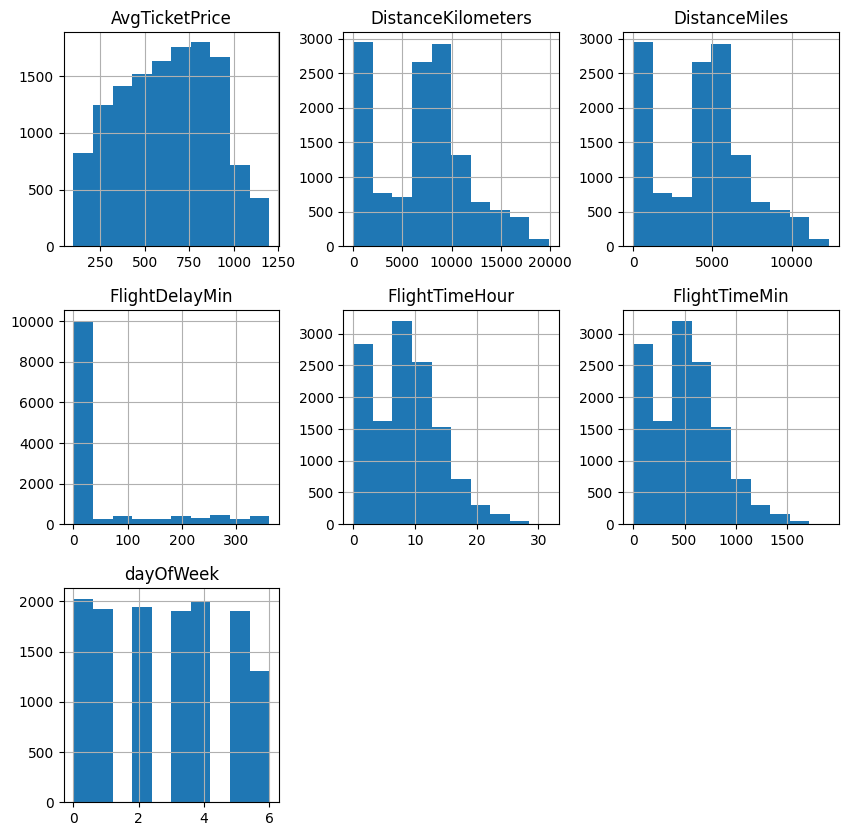

In [9]:

ed_flights.select_dtypes(include=np.number).hist(figsize=[10,10])
plt.show()